## 1. Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 2. Linear Regression Class

In [30]:
class LinearRegressionGD:
    """
    A custom Linear Regression implementation using Gradient Descent.
    Supports automatic feature scaling and one-hot encoding for categorical data.
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, normalize=True):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.normalize = normalize
        
        # Model Parameters
        self.weights = None
        self.bias = None
        self.cost_history = []
        
        # Engineering Metadata (to ensure train/test consistency)
        self.training_columns = None
        self.mean = None
        self.std = None

    def fit(self, X, y):
        # One-Hot Encoding (Handling Categorical Data)
        X_processed = pd.get_dummies(X, drop_first=True)
        X_processed = X_processed.astype(float)
        
        # Save columns to enforce schema consistency during prediction
        self.training_columns = X_processed.columns
        X_matrix = X_processed.values

        # Feature Scaling (Z-Score Normalization)
        if self.normalize:
            # Calculate and store mean/std from the training set
            self.mean = np.mean(X_matrix, axis=0)
            self.std = np.std(X_matrix, axis=0)
            
            # Add epsilon to prevent division by zero in constant columns
            self.std[self.std == 0] = 1e-8
            
            # Apply scaling: z = (x - mean) / std
            X_matrix = (X_matrix - self.mean) / self.std

        # Parameter Initialization
        n_samples, n_features = X_matrix.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.cost_history = []

        # Gradient Descent Loop
        for _ in range(self.n_iterations):
            # Prediction
            y_predicted = np.dot(X_matrix, self.weights) + self.bias
            residuals = y_predicted - y
            
            # Gradient Calculation
            dw = (1 / n_samples) * np.dot(X_matrix.T, residuals)
            db = (1 / n_samples) * np.sum(residuals)
            
            # Update Weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Track Cost (MSE)
            cost = np.mean(residuals ** 2)
            self.cost_history.append(cost)

    def predict(self, X):
        # Processing & Alignment
        X_processed = pd.get_dummies(X, drop_first=True)

        # Enforce the same columns as training (fill missing with 0)
        X_processed = X_processed.reindex(columns=self.training_columns, fill_value=0)
        X_processed = X_processed.astype(float)
        X_matrix = X_processed.values
        
        # Feature Scaling (using stored training stats)
        if self.normalize:
            X_matrix = (X_matrix - self.mean) / self.std
        
        return np.dot(X_matrix, self.weights) + self.bias

## 3. Synthetic Data Generation

In [36]:
# 1. Configuration
np.random.seed(6)  # Ensures reproducibility
n_samples = 10000

# GENERATING NUMERICAL FEATURES ----

# Rainfall: Normal Distribution (Mean=1200mm, Std=200mm)
rainfall = np.random.normal(1200, 200, n_samples)

# Fertilizer: Uniform Distribution (50 to 400 kg/ha)
fertilizer = np.random.uniform(50, 400, n_samples)

# Soil pH: Normal Distribution (Mean=6.5, Std=0.5)
ph_level = np.random.normal(6.5, 0.5, n_samples)


# GENERATING CATEGORICAL FEATURES ----

# Soil Type
soil_types = np.random.choice(['Loam', 'Clay', 'Sandy'], n_samples)

# Seed Variety
seed_varieties = np.random.choice(['Standard', 'Super_Hybrid', 'Drought_Resistant'], n_samples)


# DEFINING "GROUND TRUTH" (Target Generation) ----
# We define the exact weights the model should learn.

# Base Bias (Intercept)
true_bias = 2.0 

# Numerical Effects (True Weights)
y_simulated = true_bias + (0.003 * rainfall) + (0.015 * fertilizer) + (0.5 * ph_level)

# Categorical Effects (Simulating Dummy Weights)
soil_effects = pd.Series(soil_types).map({
    'Loam': 0,      # Baseline (Reference)
    'Clay': -0.5,
    'Sandy': -1.2
})

seed_effects = pd.Series(seed_varieties).map({
    'Standard': 0,           # Baseline (Reference)
    'Super_Hybrid': 1.5,
    'Drought_Resistant': 0.8
})

# Adding Random Noise
noise = np.random.normal(0, 0.5, n_samples) 

# Final Target Variable
y_final = y_simulated + soil_effects + seed_effects + noise

# DATAFRAME CREATION ---
df_synthetic = pd.DataFrame({
    'Rainfall_mm': rainfall,
    'Fertilizer_kg': fertilizer,
    'Soil_pH': ph_level,
    'Soil_Type': soil_types,
    'Seed_Variety': seed_varieties,
    'Yield_ton_ha': y_final
})

# Displaying dataset statistics to highlight scale differences
print("=== Synthetic Dataset Generated ===")
print("\nStatistics:")
print(df_synthetic.describe().round(2))

=== Synthetic Dataset Generated ===

Statistics:
       Rainfall_mm  Fertilizer_kg   Soil_pH  Yield_ton_ha
count     10000.00       10000.00  10000.00      10000.00
mean       1202.85         224.06      6.50         12.42
std         198.53         100.57      0.50          1.88
min         339.48          50.02      4.62          6.69
25%        1068.72         136.49      6.16         11.03
50%        1203.31         223.76      6.50         12.40
75%        1338.55         310.88      6.84         13.80
max        2075.62         400.00      8.71         18.71


## 4. Data Splitting, Model Training, and Evaluation

Training samples: 8000
Testing samples:  2000

Training in progress...
Training completed!

=== Model Performance on Test Set ===
RMSE: 0.5110 tons/ha
MAE:  0.4052 tons/ha
MAPE: 3.33 %
--------------------------------------------------
Interpretation: On average, the model error is 0.41 tons/ha.
This represents a percentage error of approximately 3.33% relative to actual yields.

--- Learned Weights (Feature Importance) ---
Bias (Intercept): 12.3283
                     Feature  Weight (Coefficient)
1              Fertilizer_kg              1.486316
0                Rainfall_mm              0.600983
5      Seed_Variety_Standard             -0.370334
6  Seed_Variety_Super_Hybrid              0.330918
4            Soil_Type_Sandy             -0.321438
2                    Soil_pH              0.236248
3             Soil_Type_Loam              0.231126


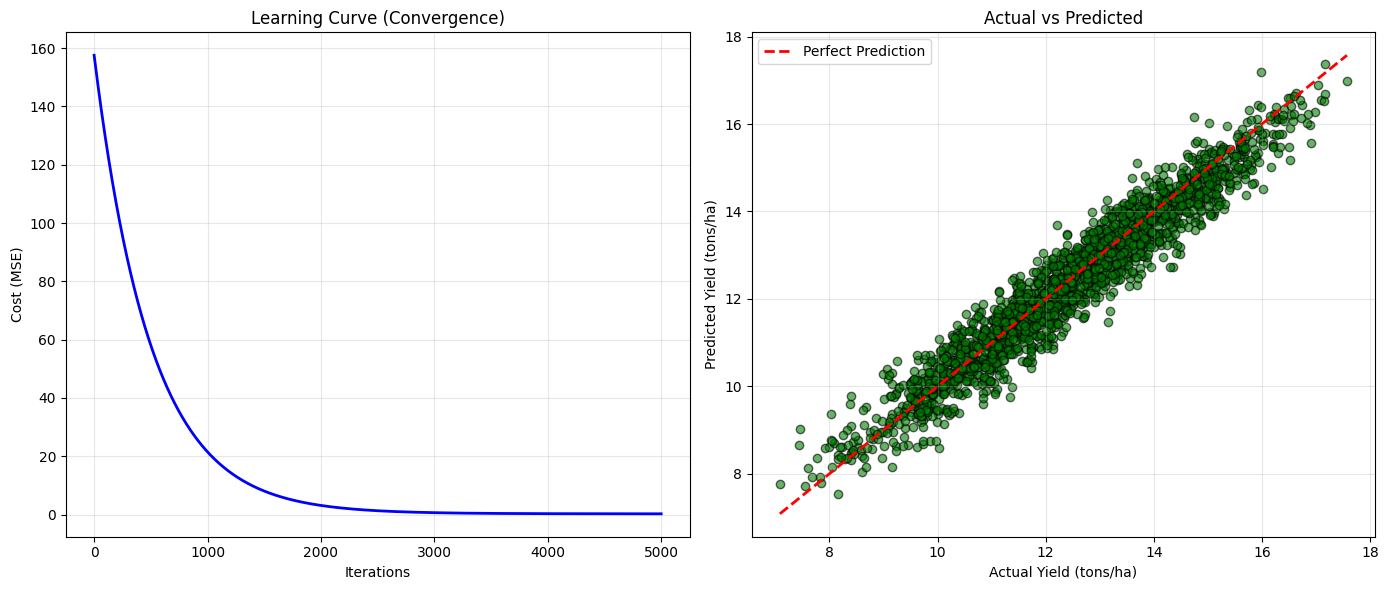

In [37]:
# Helper Function: Train-Test Split
def custom_train_test_split(X, y, test_size=0.2, random_seed=6):
    """
    Splits the dataset into training and testing sets.
    Replicates the functionality of sklearn.model_selection.train_test_split.
    """
    np.random.seed(random_seed)
    
    # Shuffle indices
    indices = np.random.permutation(len(X))
    
    # Calculate split index
    test_samples = int(len(X) * test_size)
    
    # Slice indices
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    return (X.iloc[train_indices], X.iloc[test_indices], 
            y.iloc[train_indices], y.iloc[test_indices])


# Define Features (X) and Target (y) using the synthetic dataframe
X = df_synthetic.drop('Yield_ton_ha', axis=1)
y = df_synthetic['Yield_ton_ha']

# Apply custom split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

# Model Training
# Normalization is enabled to handle the scale difference (e.g., Rainfall vs pH).
model = LinearRegressionGD(learning_rate=0.001, n_iterations=5000, normalize=True)

print("\nTraining in progress...")
model.fit(X_train, y_train)
print("Training completed!")

# Evaluation Metrics
predictions = model.predict(X_test)

# RMSE (Root Mean Squared Error)
mse = np.mean((y_test - predictions) ** 2)
rmse = np.sqrt(mse)

# MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_test - predictions))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-10))) * 100

# PERFORMANCE REPORT ---
print(f"\n=== Model Performance on Test Set ===")
print(f"RMSE: {rmse:.4f} tons/ha")
print(f"MAE:  {mae:.4f} tons/ha")
print(f"MAPE: {mape:.2f} %")

print("-" * 50)
print(f"Interpretation: On average, the model error is {mae:.2f} tons/ha.")
print(f"This represents a percentage error of approximately {mape:.2f}% relative to actual yields.")

# Feature Importance (Learned Weights)
weights_df = pd.DataFrame({
    'Feature': model.training_columns,
    'Weight (Coefficient)': model.weights
})

# Sort by absolute impact to identify most influential factors
weights_df['Abs_Impact'] = weights_df['Weight (Coefficient)'].abs()
weights_df = weights_df.sort_values(by='Abs_Impact', ascending=False)

print("\n--- Learned Weights (Feature Importance) ---")
print(f"Bias (Intercept): {model.bias:.4f}")
print(weights_df[['Feature', 'Weight (Coefficient)']])

# Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Learning Curve
plt.subplot(1, 2, 1)
plt.plot(model.cost_history, color='blue', linewidth=2)
plt.title('Learning Curve (Convergence)')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.6, color='green', edgecolors='k')

# Identity Line (Perfect Prediction)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Yield (tons/ha)')
plt.ylabel('Predicted Yield (tons/ha)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Custom Model vs. Scikit-Learn

**Note:** Since the custom class (`LinearRegressionGD`) handles One-Hot Encoding and Feature Scaling internally, we must **manually replicate** these preprocessing steps for Scikit-Learn to ensure a mathematically fair comparison.


METRIC     | CUSTOM MODEL         | SCIKIT-LEARN         | DIFFERENCE     
---------------------------------------------------------------------------
RMSE       | 0.51104              | 0.50467              | 0.00638        
MAE        | 0.40522              | 0.40136              | 0.00386        
MAPE (%)   | 3.3305               | 3.3237               | 0.0068         
---------------------------------------------------------------------------

The results are statistically identical.
Our custom Gradient Descent implementation matches the OLS industry standard.
Final Error (MAPE): 3.33%


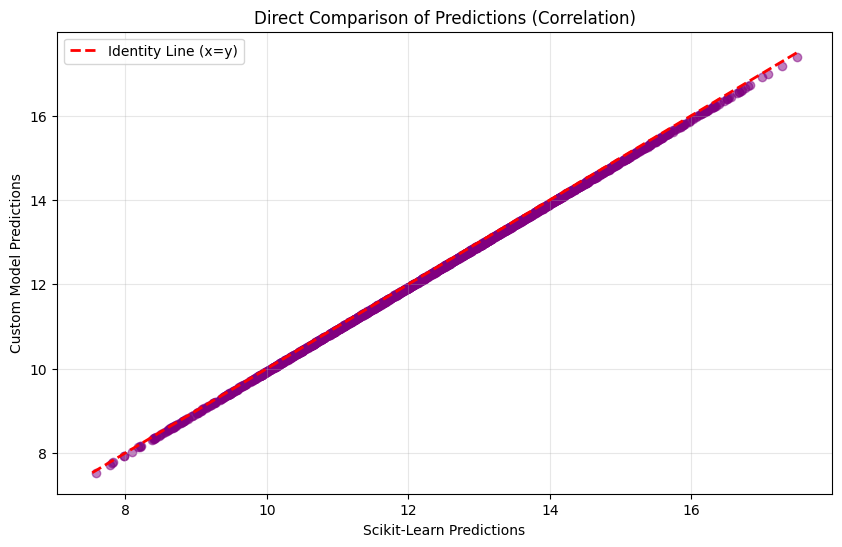

In [38]:

# PREPROCESSING FOR SCIKIT-LEARN ----

# One-Hot Encoding
X_train_sklearn = pd.get_dummies(X_train, drop_first=True, dtype=float)
X_test_sklearn = pd.get_dummies(X_test, drop_first=True, dtype=float)

# Column Alignment
model_cols = model.training_columns 
X_train_sklearn = X_train_sklearn.reindex(columns=model_cols, fill_value=0)
X_test_sklearn = X_test_sklearn.reindex(columns=model_cols, fill_value=0)

# Feature Scaling
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_sklearn)
X_test_final = scaler.transform(X_test_sklearn)


# TRAINING ----

# Scikit-Learn
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_final, y_train)

# Custom Class: Already trained in the 'model' variable (Uses Gradient Descent)


# PREDICTION & METRICS COMPARISON ----

# Generate Predictions
preds_custom = model.predict(X_test)     
preds_sklearn = sklearn_model.predict(X_test_final)


# CALCULATING METRICS -----

# RMSE (Root Mean Squared Error)
rmse_custom = np.sqrt(mean_squared_error(y_test, preds_custom))
rmse_sklearn = np.sqrt(mean_squared_error(y_test, preds_sklearn))

# MAE (Mean Absolute Error)
mae_custom = mean_absolute_error(y_test, preds_custom)
mae_sklearn = mean_absolute_error(y_test, preds_sklearn)

# MAPE (Mean Absolute Percentage Error)
mape_custom = np.mean(np.abs((y_test - preds_custom) / (y_test + 1e-10))) * 100
mape_sklearn = np.mean(np.abs((y_test - preds_sklearn) / (y_test + 1e-10))) * 100


# COMPARISON TABLE ----
print(f"\n{'METRIC':<10} | {'CUSTOM MODEL':<20} | {'SCIKIT-LEARN':<20} | {'DIFFERENCE':<15}")
print("-" * 75)

# RMSE
diff_rmse = abs(rmse_custom - rmse_sklearn)
print(f"{'RMSE':<10} | {rmse_custom:<20.5f} | {rmse_sklearn:<20.5f} | {diff_rmse:<15.5f}")

# MAE
diff_mae = abs(mae_custom - mae_sklearn)
print(f"{'MAE':<10} | {mae_custom:<20.5f} | {mae_sklearn:<20.5f} | {diff_mae:<15.5f}")

# MAPE
diff_mape = abs(mape_custom - mape_sklearn)
print(f"{'MAPE (%)':<10} | {mape_custom:<20.4f} | {mape_sklearn:<20.4f} | {diff_mape:<15.4f}")

print("-" * 75)


# FINAL RESULTS ----

if diff_rmse < 0.05:
    print(f"\nThe results are statistically identical.")
    print(f"Our custom Gradient Descent implementation matches the OLS industry standard.")
    print(f"Final Error (MAPE): {mape_custom:.2f}%")
else:
    print(f"\n⚠️ DIVERGENCE DETECTED. Check learning_rate or iteration count.")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(preds_sklearn, preds_custom, alpha=0.5, color='purple')

# Identity Line (x=y)
min_val = min(preds_sklearn.min(), preds_custom.min())
max_val = max(preds_sklearn.max(), preds_custom.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Identity Line (x=y)')

plt.xlabel('Scikit-Learn Predictions')
plt.ylabel('Custom Model Predictions')
plt.title(f'Direct Comparison of Predictions (Correlation)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()